In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.wcs import WCS
from astropy.table import Table
import pandas as pd
import seaborn as sns
import scipy as sp
from funciones import *
from astropy.io import ascii

In [2]:
#pip install random
#mpl.rcParams('axes.color_cycle') = mpl.cycler('color' , ['#129845','#271254', '#FA4411', '#098765', '#000009'])

In [3]:
mastar = fits.open('data/mastar-catalogue.fits.gz')

In [4]:
ssps = fits.open('data/ssps/ssp-z0.0190.fits.gz')

In [5]:
isoc = ascii.read('data/isochrones/isoc_z0.0190.dat')

In [6]:
wavelength = np.arange(mastar['SPECTRA'].header['CRPIX1']-1 , mastar['SPECTRA'].data.shape[1]) + mastar['SPECTRA'].header['CRVAL1']

In [7]:
spectra = Table(mastar['SPECTRA'].data).to_pandas() #espectros

In [8]:
catalog = Table(mastar['CATALOGUE'].data).to_pandas() #paraemtros fisicos

In [9]:
labels = ['TEFF', 'LOGG', 'MET' , 'ALPHAM']
#sns.pairplot(catalog[labels])
    #plotear las propiedades fisicas

In [10]:
params = catalog[labels] #Teff , log(g) , met , alpham
teff = params['TEFF']
logg = params['LOGG']
met = params['MET']
alpham = params['ALPHAM']

In [11]:
#funcion(tabla , N(#de muestras q quiero sacar de la tabla, aleatoria y con reemplazo)) 
#=> indices que saco que mapea las dos tablas, dos tablas 
#selecciona los espectros de esos indices
#con eso hago una funcion, ajuste o fiteo (espectro[i](N espectros) , espectro que quiero ajustar(el de una poblacion simple))
#fM(N espectros y N pesos) f modelo
#minimizar xi cuadrado

In [12]:
#random_index , random_parameters , random_spectra = random_extract(100 , reset_index = True)

In [13]:
# con scipy.optimize.nnls(N espectro en columnas (lo tengo en filas , transponer) y espectro problema (fila , transponer)) 
#=> da los pesos de cada espectro 
# con los pesos los pondero con las i-esimos espectro para tener fm (espectro modelo) a partir de los N espectro aleatrorios
#pintar los espectro modelos en el espacio de parametros fisicos

In [14]:
#pesos , res = get_weights(random_parameters[2] , spectra.loc[1000])

#plt.plot(wavelength , fm(random_parameters[2] , pesos))
#plt.plot(wavelength , spectra.loc[1000])
#plt.xlabel('Wavelength (Angstroms)')
#plt.show()

In [15]:
#kde en puntos, el espectro obs y los N puntos aleatorios, en logg/teff
#funcion(parametro x parametro , N puntos muestreados , espectro_obs en el espacio de parametros) => (le hace la kde)
#funcion(m repeticiones de N muestras , N)=>ir guardando, da todas las iteraciones, 
#=>es la m-esima iteracion mejor q la anterior?
#append de cada iteracion de resultado de muestreo aleatorio y de res y pesos

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
obs_index = 451

m = 100
N = 100
ran_index , ran_parameters , ran_spectra , ran_weights , ran_res = iterative_fits(spectra , params , spectra.loc[obs_index] , m , N, repetition = False)
min_index , min_parameters , min_spectra , min_weights , min_res = min_res_fits(ran_index , ran_parameters , ran_spectra , ran_weights , ran_res)
nonzero_total , nonzero_spectra , nonzero_parameters , nonzero_weights = get_nonzero_spectra(ran_spectra , ran_parameters , ran_weights)

In [18]:
parameter1 = 'TEFF'
parameter2 = 'LOGG'

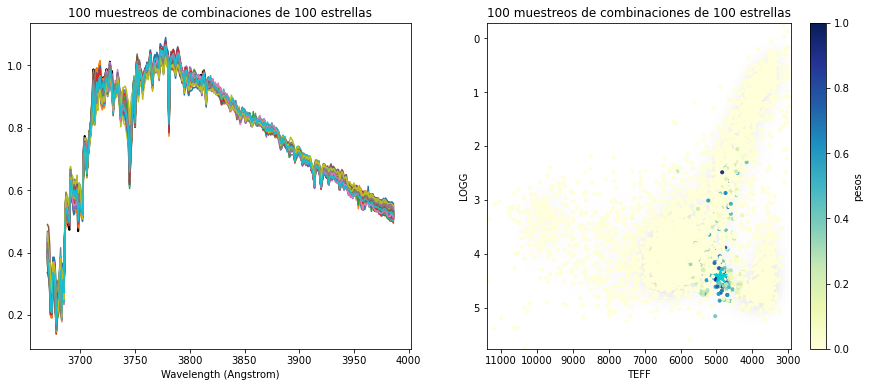

In [19]:
fig , axs = plt.subplots(ncols = 2, figsize = (15,6))

plt.subplot(1,2,1,) #espectros

plot_spectra(m ,wavelength, ran_spectra , ran_weights  , spectra.loc[obs_index], plot_err = False)
axs[0].set_xlabel('Wavelength (Angstrom)')
axs[0].set_title(str(m)+' muestreos de combinaciones de '+str(N)+' estrellas')

plt.subplot(1,2,2) #parametros
plot_kde(parameter1 , parameter2 , params , params.loc[obs_index])
map_parameters(m , parameter1 , parameter2 , ran_parameters , params.loc[[obs_index]] , ran_weights)
axs[1].invert_xaxis()
axs[1].invert_yaxis()
axs[1].set_xlabel(parameter1)
axs[1].set_ylabel(parameter2)
axs[1].set_title(str(m)+' muestreos de combinaciones de '+str(N)+' estrellas')
plt.show()

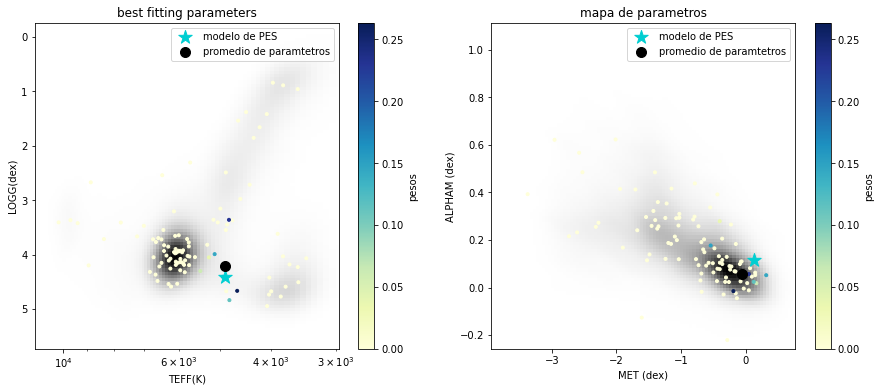

In [25]:
fig , axs = plt.subplots(ncols = 2, figsize = (15,6))
plt.subplot(1,2,1,)
plot_kde(parameter1 , parameter2 , params , params.loc[obs_index]) #muestra la kde
map_parameters(1 , parameter1 , parameter2 , min_parameters , params.loc[[obs_index]] , min_weights) #mapea parametros
plot_mean_parameters(m , parameter1 , parameter2 , min_parameters , min_weights)



axs[0].set_xlim(np.min(teff),np.max(teff))  
axs[0].set_ylim(np.min(logg),np.max(logg))  
axs[0].invert_xaxis()
axs[0].invert_yaxis()
axs[0].semilogx()
axs[0].legend()
axs[0].set_xlabel(parameter1+'(K)')
axs[0].set_ylabel(parameter2+'(dex)')


axs[0].set_title('best fitting parameters')
plt.subplot(1,2,2,)
plot_kde('MET' , 'ALPHAM' , params)
map_parameters(1 , 'MET' , 'ALPHAM' , min_parameters , params.loc[[obs_index]] ,min_weights)
plot_mean_parameters(m , 'MET' , 'ALPHAM' , min_parameters , min_weights)

axs[1].set_xlim(np.min(met),np.max(met))
axs[1].set_ylim(np.min(alpham),np.max(alpham))
#axs.invert_xaxis()
#axs.invert_yaxis()
axs[1].legend()
axs[1].set_xlabel('MET (dex)')
axs[1].set_ylabel('ALPHAM (dex)')
axs[1].set_title('mapa de parametros')

fig.savefig('bestfitting_parameters_'+parameter1+'_'+parameter2+'.png')

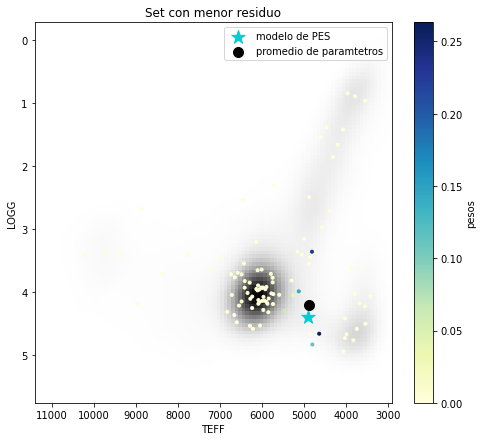

In [20]:
fig , axs = plt.subplots(ncols = 1, figsize = (8,7))
plt.subplot(1,1,1,) #scatter de la iteracion con menos residuo↓↓↓↓↓↓

plot_kde(parameter1 , parameter2 , params , params.loc[obs_index]) #muestra la kde
map_parameters(1 , parameter1 , parameter2 , min_parameters , params.loc[[obs_index]] , min_weights) #mapea parametros
plot_mean_parameters(m , parameter1 , parameter2 , min_parameters , min_weights) #plotea el promedio ponderado de parametros
axs.invert_xaxis() #invert x axis
axs.invert_yaxis() #invert y axis
axs.set_xlabel(parameter1) #name x axis
axs.set_ylabel(parameter2) #name y axis
axs.set_title('Set con menor residuo') #fig. title
axs.legend()
plt.show()

In [ ]:
#pick best fiting spectrum from m realizations of N
#min(res)
#plot(fm-obs_spectrum), 
#ran_weights

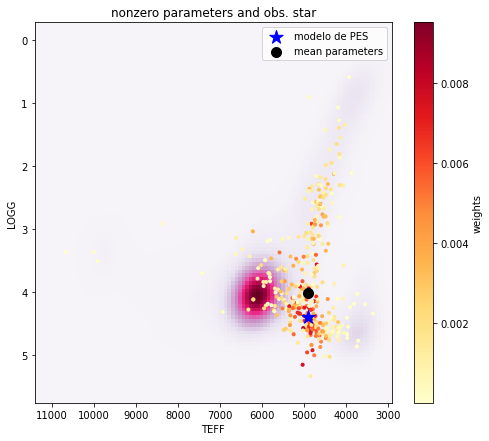

In [39]:
fig , axs = plt.subplots(ncols = 1, figsize = (8,7))
plot_kde(parameter1 , parameter2 , params , params.loc[obs_index])
map_parameters(1, parameter1 , parameter2 , nonzero_parameters , params.loc[[obs_index]] ,nonzero_weights)
plot_mean_parameters(m , parameter1 , parameter2 , nonzero_parameters , nonzero_weights) 
axs.invert_xaxis()
axs.invert_yaxis()
axs.set_xlabel(parameter1)
axs.set_ylabel(parameter2)
plt.title('nonzero parameters and obs. star')
plt.legend()
plt.show()

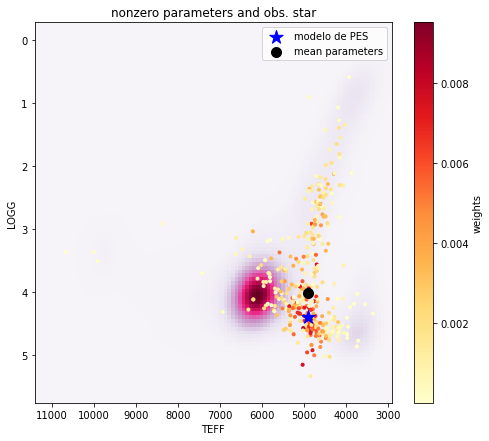

In [42]:
fig , axs = plt.subplots(ncols = 1, figsize = (8,7))
plot_kde(parameter1 , parameter2 , params , params.loc[obs_index])
map_parameters(1 , parameter1 , parameter2 , nonzero_parameters , params.loc[[obs_index]] ,nonzero_weights)
plot_mean_parameters(m , parameter1 , parameter2 , nonzero_parameters , nonzero_weights) 
axs.invert_xaxis()
axs.invert_yaxis()
axs.set_xlabel(parameter1)
axs.set_ylabel(parameter2)
plt.title('nonzero parameters and obs. star')
plt.legend()

In [126]:
#prueba = pickrandom(10)
#test = np.array((1,1))
#test2 = np.array((2,2))
#locura = [params.loc[test] , params.loc[test2]]
#locura[0] , locura[1]
#plot_kde(parameter1 , parameter2 , ran_parameters , params.loc[obs_index])

In [43]:
pdf = sp.stats.gaussian_kde(teff, bw_method=10, weights=None) #funcion de probabilidad estimada, para teff

In [ ]:
#plt.scatter(catalog.GSDSS-catalog.RSDSS,catalog['TEFF'])

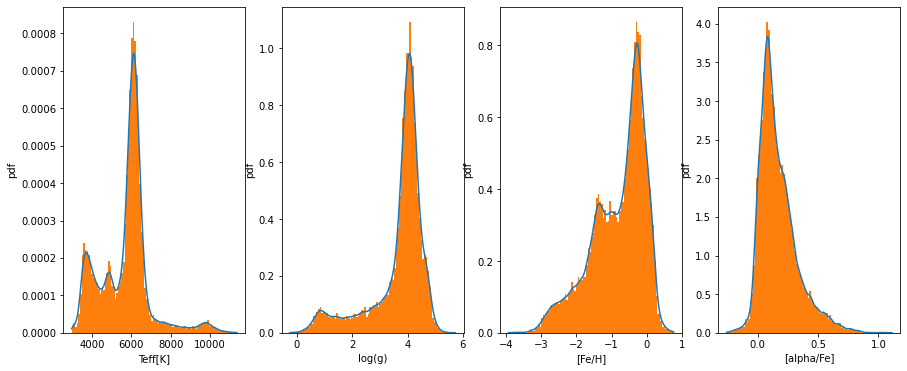

In [44]:
### TEFF ###
eval_points_teff = np.linspace(np.min(teff), np.max(teff),1000)
pdf_teff = sp.stats.gaussian_kde(teff, bw_method=.1, weights=None)
ykde_teff = pdf_teff(eval_points_teff)

### LOGG ###
eval_points_logg = np.linspace(np.min(logg), np.max(logg),1000)
pdf_logg = sp.stats.gaussian_kde(logg, bw_method=.1, weights=None)
ykde_logg = pdf_logg(eval_points_logg)

### MET ###
eval_points_met = np.linspace(np.min(met), np.max(met),1000)
pdf_met = sp.stats.gaussian_kde(met, bw_method=.1, weights=None)
ykde_met = pdf_met(eval_points_met)

### ALPHAM ###
eval_points_alpham = np.linspace(np.min(alpham), np.max(alpham),1000)
pdf_alpham = sp.stats.gaussian_kde(alpham, bw_method=.1, weights=None)
ykde_alpham = pdf_alpham(eval_points_alpham)

fig , axs = plt.subplots(ncols = 4, figsize = (15,6))
axs[0].plot(eval_points_teff , ykde_teff)
axs[0].hist(teff , density = True , bins = 100)
axs[0].set_xlabel("Teff[K]")
axs[0].set_ylabel('pdf')

axs[1].plot(eval_points_logg , ykde_logg)
axs[1].hist(logg , density = True , bins = 100)
axs[1].set_xlabel("log(g)")
axs[1].set_ylabel('pdf')

axs[2].plot(eval_points_met , ykde_met)
axs[2].hist(met , density = True , bins = 100)
axs[2].set_xlabel("[Fe/H]")
axs[2].set_ylabel('pdf')

axs[3].plot(eval_points_alpham , ykde_alpham)
axs[3].hist(alpham , density = True , bins = 100)
axs[3].set_xlabel("[alpha/Fe]")
axs[3].set_ylabel('pdf')
plt.show()
#sns.kdeplot(catalog['TEFF'])

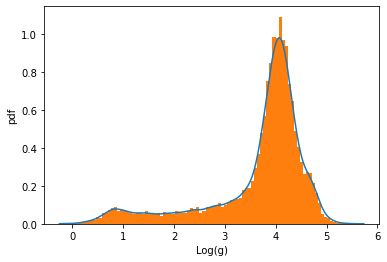

In [45]:
eval_points = np.linspace(np.min(logg), np.max(logg),1000)
pdf = sp.stats.gaussian_kde(logg, bw_method=.1, weights=None)
ykde = pdf(eval_points)
plt.plot(eval_points , ykde)
plt.hist(catalog['LOGG'] , density = True , bins = 100)
plt.xlabel("Log(g)")
plt.ylabel('pdf')
plt.show()

X, Y, Z, W = np.mgrid[np.min(catalog['TEFF']):np.max(catalog['TEFF']):50j , np.min(catalog['LOGG']):np.max(catalog['LOGG']):50j , np.min(catalog['MET']):np.max(catalog['MET']):50j , np.min(catalog['ALPHAM']):np.max(catalog['ALPHAM']):50j]
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])
values = np.vstack([catalog['TEFF'], catalog['LOGG'],catalog['MET'],catalog['ALPHAM']])
kernel = sp.stats.gaussian_kde(values)
K = np.reshape(kernel(positions).T, X.shape)

In [ ]:
#arr = np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, K.shape), indexing="ij"))) + [K.ravel()])
#df = pd.DataFrame(arr, columns = ['mode' ,'TEFF', 'LOGG', 'MET', 'ALPHAM'])


d_teff = np.diff(X, axis=0).ravel()[0]
d_logg = np.diff(Y, axis=1).ravel()[0]
d_met = np.diff(Z, axis=2).ravel()[0]
d_alpham = np.diff(W, axis=3).ravel()[0]
log_vs_teff = np.sum(K , axis = (2,3)) * d_met * d_alpham
met_vs_teff = np.sum(K , axis = (0,3)) * d_logg * d_alpham
met_vs_teff = np.sum(K , axis = (0,2)) * d_logg * d_alpham
plt.pcolor(alpham_vs_met)
plt.xlabel('Teff[K]')
plt.ylabel('log(g)')
plt.show()

In [13]:
### logg vs teff ###
X1 , Y1 = np.mgrid[np.min(catalog['TEFF']):np.max(catalog['TEFF']):100j , np.min(catalog['LOGG']):np.max(catalog['LOGG']):100j]
positions1 = np.vstack([X1.ravel() , Y1.ravel()])
values1 = np.vstack([catalog['TEFF'] , catalog['LOGG']])
kernel1 = sp.stats.gaussian_kde(values1)
K1 = np.reshape(kernel1(positions1).T , X1.shape)

### Fe/H vs teff ###
X2 , Y2 = np.mgrid[np.min(teff):np.max(teff):100j, np.min(met):np.max(met):100j]
positions2 = np.vstack([X2.ravel() , Y2.ravel()])
values2 = np.vstack([teff , met])
kernel2 = sp.stats.gaussian_kde(values2)
K2 = np.reshape(kernel2(positions2).T , X2.shape)

X3 , Y3 = np.mgrid[np.min(teff):np.max(teff):100j, np.min(alpham):np.max(alpham):100j]
positions3 = np.vstack([X3.ravel() , Y3.ravel()])
values3 = np.vstack([teff , alpham])
kernel3 = sp.stats.gaussian_kde(values3)
K3 = np.reshape(kernel3(positions3).T , X3.shape)

X4 , Y4 = np.mgrid[np.min(logg):np.max(logg):100j, np.min(met):np.max(met):100j]
positions4 = np.vstack([X4.ravel() , Y4.ravel()])
values4 = np.vstack([logg , met])
kernel4 = sp.stats.gaussian_kde(values4)
K4 = np.reshape(kernel4(positions4).T , X4.shape)

X5 , Y5 = np.mgrid[np.min(logg):np.max(logg):100j, np.min(alpham):np.max(alpham):100j]
positions5 = np.vstack([X5.ravel() , Y5.ravel()])
values5 = np.vstack([logg , alpham])
kernel5 = sp.stats.gaussian_kde(values5)
K5 = np.reshape(kernel5(positions5).T , X5.shape)

X6 , Y6 = np.mgrid[np.min(met):np.max(met):100j, np.min(alpham):np.max(alpham):100j]
positions6 = np.vstack([X6.ravel() , Y6.ravel()])
values6 = np.vstack([met , alpham])
kernel6 = sp.stats.gaussian_kde(values6)
K6 = np.reshape(kernel6(positions6).T , X6.shape)

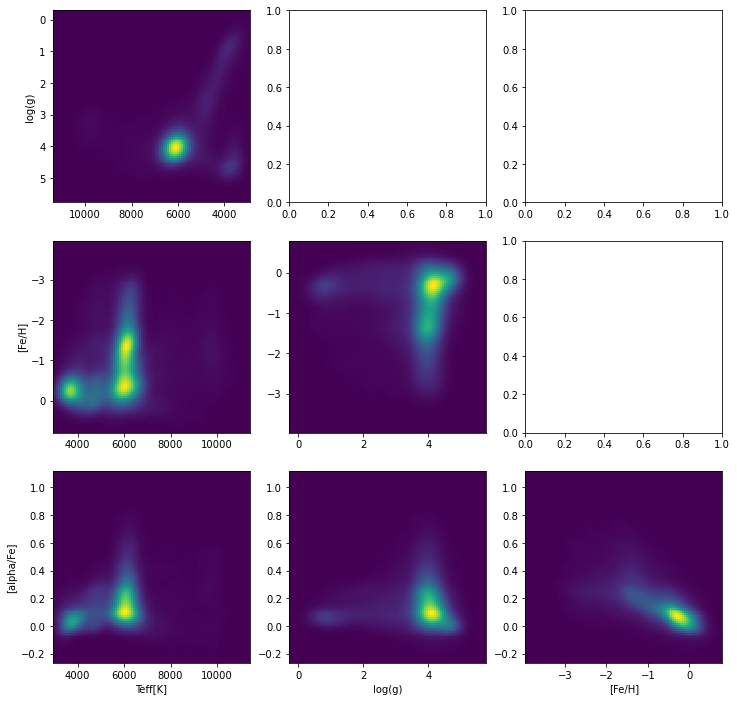

In [21]:
fig , ax = plt.subplots(3,3 , figsize = (12,12))
ax[0,0].pcolor(X1 , Y1 ,K1)
 
ax[0,0].invert_xaxis()
ax[0,0].invert_yaxis()
ax[0,0].set_ylabel('log(g)')

ax[1,0].pcolor(X2 , Y2 , K2)
#ax[1,0].invert_xaxis()
ax[1,0].invert_yaxis()
ax[1,0].set_ylabel('[Fe/H]')

ax[2,0].pcolor(X3 , Y3 , K3)
ax[2,0].set_xlabel('Teff[K]')
ax[2,0].set_ylabel('[alpha/Fe]')

ax[1,1].pcolor(X4 , Y4 , K4)

ax[2,1].pcolor(X5 , Y5 , K5)
ax[2,1].set_xlabel('log(g)')

ax[2,2].pcolor(X6 , Y6 , K6)
ax[2,2].set_xlabel('[Fe/H]')
plt.savefig('KDES.png')